In [1]:
import pandas as pd
import numpy as np
from math import sin, cos, sqrt, atan2, radians
import random
from time import gmtime, strftime

from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
import shap

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
train = pd.read_csv('fraudTrain.csv')
test  = pd.read_csv('fraudTest.csv')

In [3]:
train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [4]:
def calc_distance(lat1, long1, lat2, long2):
    """Определение дистанции между точками
    """
    R = 6373.0 # approximate radius of earth in km
    lat1 = radians(lat1)
    lon1 = radians(long1)
    lat2 = radians(lat2)
    lon2 = radians(long2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [5]:
def preprocess_features_basic(df):
    """Функция добавляет к датафрейму аттрибуты:
    - trans_hour     - час транзакции;
    - trans_week_day - день недели транзакции;
    - birth_year     - год рождения плательщика
    - trans_distance - дистанция между местом жительства плательщика и местом транзакции
    """
    print(strftime("%Y-%m-%d %H:%M:%S", gmtime()) + ' Preprocess features: trans_hour, trans_dttm, dob, trans_week_day')
    df['trans_hour'] = df['trans_date_trans_time'].str[11:13]
    df['trans_dttm'] = pd.to_datetime(df['trans_date_trans_time'])
    df['birth_year'] = df['dob'].str[0:4].astype('int')
    df['trans_week_day'] = df['trans_dttm'].apply(lambda x: x.strftime('%A'))
    print(strftime("%Y-%m-%d %H:%M:%S", gmtime()) + ' Preprocess features: trans_distance')
    df['trans_distance'] = df.apply(lambda row: calc_distance(row["lat"], row["long"], row["merch_lat"], row["merch_long"]), axis = 1)
    return df

In [6]:
def get_feature_str(feature_name, target_name, df):
    """Определяем количество и долю единичек для аттрибута. 
    Функция возвращает датафрейм из 3х колонок: 
    наименование аттрибута, количество единичек, долю единичек для каждого значения аттрибута
    """
    agg_df = df.groupby([feature_name,target_name], as_index=False)\
            .aggregate({'unix_time' : 'count'})\
            .rename(columns = {'unix_time': 'cnt'})
    pivot_df = agg_df.pivot(index=feature_name, columns=target_name).fillna(0)
    flat_df = pd.DataFrame(pivot_df.to_records())
    flat_df.columns = [feature_name, 'target_0', 'target_1']
    flat_df['target_share'] = flat_df['target_1'] / (flat_df['target_0'] + flat_df['target_1'])
    flat_df.sort_values(by='target_share', ascending=False, inplace = True)
    flat_df.columns = [feature_name, feature_name + '_target_0_cnt', feature_name + '_target_1_cnt', feature_name + '_target_share']
    flat_df = flat_df.drop(feature_name + '_target_0_cnt', axis = 1)
    return flat_df

In [7]:
def preprocess_features_references(train, test = None, type_cd = 'train', min_typical_trans_cnt = 400):
    """Функция добавляет к датафрейму аттбируты на основании справочников, полученных из обучающей выборки:
    - life_time_days - количество дней между первой транзакцией плательщика и текущей ("время жизни плательника")
    - typical_zip    - признак того, что код локации является типовым, т.е. в нем совершено большое количество (>400) нефродовых транзакций  
    - typical_job    - признак того, что должность является типовой, т.е. для нее совершено большое количество (>400) нефродовых транзакций  
    - merchant_target_share - доля фродовых транзакций у получателя платежа
    """
    print(strftime("%Y-%m-%d %H:%M:%S", gmtime()) + ' Preprocess_features_references: zip, job, cc_num, merchant')
    zip_df = train.loc[train['is_fraud']==0,:].groupby(['zip','is_fraud'], as_index=False)\
            .aggregate({'unix_time' : 'count'})\
            .rename(columns = {'unix_time': 'cnt'})
    typical_zip = list(zip_df.loc[zip_df['cnt']>min_typical_trans_cnt,:]['zip'])
    job_df = train.loc[train['is_fraud']==0,:].groupby(['job','is_fraud'], as_index=False)\
            .aggregate({'unix_time' : 'count'})\
            .rename(columns = {'unix_time': 'cnt'})
    typical_job = list(job_df.loc[job_df['cnt']>min_typical_trans_cnt,:]['job'])
    fraudster = list(train.loc[train['is_fraud']==1,:].groupby(['cc_num','is_fraud'], as_index=False)\
            .aggregate({'unix_time' : 'count'})\
            .rename(columns = {'unix_time': 'cnt'})['cc_num'])
    cc_num_min_time = train.groupby(['cc_num'], as_index=False)\
            .aggregate({'unix_time' : 'min'})\
            .rename(columns = {'unix_time': 'first_trans_time'})
    merchant_fraud_share = get_feature_str('merchant', 'is_fraud', train)
    merchant_fraud_share.drop('merchant_target_1_cnt', axis = 1, inplace = True)
    def mark_typical_features(df,typical_zip,typical_job):
        df['typical_zip'] = df['zip'].isin(typical_zip).astype(int)
        df['typical_job'] = df['job'].isin(typical_job).astype(int)
        df['earlier_fraudster'] = df['cc_num'].isin(fraudster).astype(int)
        df = df.merge(cc_num_min_time, on='cc_num', how='left')
        df['life_time_days'] = df['unix_time'] - df['first_trans_time']
        df['life_time_days'].fillna(0, inplace = True)
        df['life_time_days'] = df['life_time_days'] / (60*60*24)
        df['life_time_days'] = df['life_time_days'].apply(lambda x: x + random.uniform(0.05,0.5))
        df['life_time_days'] = df['life_time_days'].round(3)
        df = df.merge(merchant_fraud_share, on='merchant', how='left')
        df['merchant_target_share'].fillna(0, inplace = True)
        return df
    if type_cd == 'train':
        train = mark_typical_features(train,typical_zip,typical_job)
        return train
    if type_cd == 'test':
        test = mark_typical_features(test,typical_zip,typical_job)
        return test

In [8]:
def delete_unwanted_features(df):
    """ Удалим лишние аттрибуты
    """
    print(strftime("%Y-%m-%d %H:%M:%S", gmtime()) + ' Deleting unwanted features')
    features_to_delete = ['Unnamed: 0','trans_date_trans_time','cc_num','merchant',
                          'first','last','street','city','state','zip','lat','long',
                          'job','dob','trans_num','unix_time','merch_lat','merch_long',
                          'trans_dttm','first_trans_time']
    df.drop(features_to_delete, axis = 1, inplace = True)
    return df

In [9]:
def one_hot_encode(df, col_name):
    """ Функция выполняет one hot encoding по списку аттрибутов
    """
    for i in list(col_name):
        print(strftime("%Y-%m-%d %H:%M:%S", gmtime()) + ' One hot encoding: ' + i)
        one_hot = pd.get_dummies(df[i])
        one_hot.columns = i + '_' + one_hot.columns
        df = df.drop(i, axis = 1)
        df = df.join(one_hot)
    return df

In [47]:
def min_max_scale(df, feature_name_list):
    """ Функция выполняет min-max нормализацию аттрибутов: (x - min_x) / (max_x-min_x)
    """
    for feature_name in list(feature_name_list):
        print(strftime("%Y-%m-%d %H:%M:%S", gmtime()) + ' Min_max_scale: ' + feature_name)
        min_x = df[feature_name].min()
        max_x = df[feature_name].max()
        df[feature_name+'_norm'] = df[feature_name].apply(lambda x: (x - min_x) / (max_x-min_x))
        df = df.drop(feature_name, axis = 1)
    return df

In [54]:
def std_scale(df, feature_name_list):
    """Функция выполняет Z-нормализацию аттрибутов: (x - mean) / standard_deviation
    """
    for feature_name in list(feature_name_list):
        print(strftime("%Y-%m-%d %H:%M:%S", gmtime()) + ' Min_max_scale: ' + feature_name)
        mean_x = df[feature_name].mean()
        std_x = df[feature_name].std()
        df[feature_name+'_stdnorm'] = df[feature_name].apply(lambda x: (x - mean_x) / (std_x))
        df = df.drop(feature_name, axis = 1)
    return df

In [10]:
train_1 = preprocess_features_basic(train)
train_2 = preprocess_features_references(train = train_1, type_cd = 'train')
train_3 = delete_unwanted_features(train_2)
train_4 = one_hot_encode(train_3, ['category','gender','trans_hour', 'trans_week_day'])

2020-11-10 19:21:29 Preprocess features: trans_hour, trans_dttm, dob, trans_week_day
2020-11-10 19:21:42 Preprocess features: trans_distance
2020-11-10 19:23:03 Preprocess_features_references: zip, job, cc_num, merchant
2020-11-10 19:23:11 Deleting unwanted features
2020-11-10 19:23:12 One hot encoding: category
2020-11-10 19:23:13 One hot encoding: gender
2020-11-10 19:23:13 One hot encoding: trans_hour
2020-11-10 19:23:14 One hot encoding: trans_week_day


In [11]:
test_1 = preprocess_features_basic(test)
test_2 = preprocess_features_references(train = train_1, test = test_1, type_cd = 'test')
test_3 = delete_unwanted_features(test_2)
test_4 = one_hot_encode(test_3, ['category','gender','trans_hour', 'trans_week_day'])

2020-11-10 19:23:15 Preprocess features: trans_hour, trans_dttm, dob, trans_week_day
2020-11-10 19:23:20 Preprocess features: trans_distance
2020-11-10 19:23:55 Preprocess_features_references: zip, job, cc_num, merchant
2020-11-10 19:23:58 Deleting unwanted features
2020-11-10 19:23:59 One hot encoding: category
2020-11-10 19:23:59 One hot encoding: gender
2020-11-10 19:23:59 One hot encoding: trans_hour
2020-11-10 19:23:59 One hot encoding: trans_week_day


# Train model

In [68]:
X = train_4.drop('is_fraud', axis = 1)
#X = preprocessing.scale(X)
y = train_4.loc[:,'is_fraud']

In [69]:
features_to_scale = ['amt','city_pop', 'trans_distance', 'life_time_days', 
                     'merchant_target_share','birth_year']
X = min_max_scale(X, features_to_scale)

2020-11-10 20:08:53 Min_max_scale: amt
2020-11-10 20:08:53 Min_max_scale: city_pop
2020-11-10 20:08:54 Min_max_scale: trans_distance
2020-11-10 20:08:55 Min_max_scale: life_time_days
2020-11-10 20:08:55 Min_max_scale: merchant_target_share
2020-11-10 20:08:56 Min_max_scale: birth_year


In [70]:
model = XGBClassifier(nthread=-1)#, learning_rate=0.1, n_estimators=10)

In [71]:
model.fit(X, y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1289169
           1       0.98      0.88      0.92      7506

    accuracy                           1.00   1296675
   macro avg       0.99      0.94      0.96   1296675
weighted avg       1.00      1.00      1.00   1296675

[[1289024     145]
 [    927    6579]]


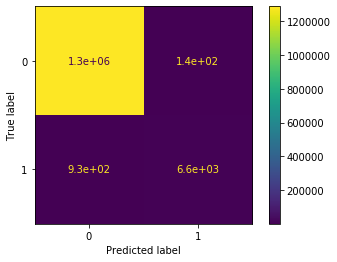

In [72]:
# summarize the fit of the model
expected = y
predicted = model.predict(X)
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
plot_confusion_matrix(model, X, y)

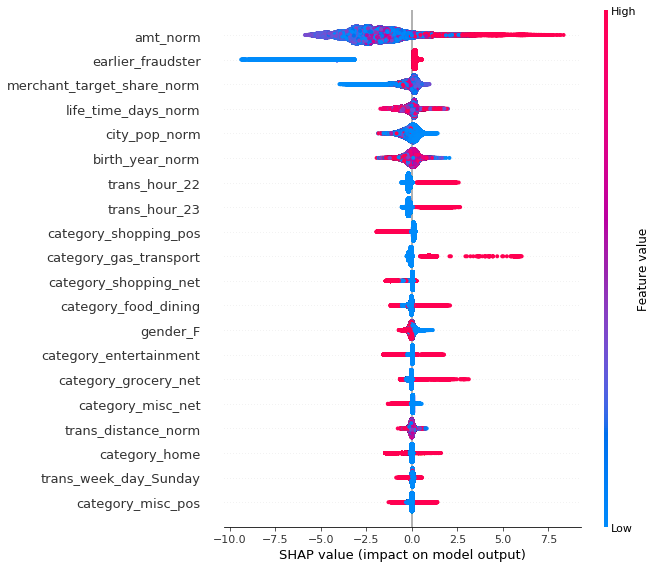

In [77]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

# Export y_probas

In [22]:
y_true = y # ground truth labels
y_probas = model.predict_proba(X) # predicted probabilities generated by sklearn classifier
#skplt.metrics.plot_roc(y_true, y_probas)
#plt.show()
data_tuples = list(zip(y_true,list(y_probas[:,1])))
compare = pd.DataFrame(data_tuples, columns=['y_true','y_probas'])
compare['y_probas'] = compare['y_probas'].round(2)
compare.head(500000).to_excel('compare_5.xlsx', index = False)

# Test model

In [75]:
X = test_4.drop('is_fraud', axis = 1)
X = min_max_scale(X, features_to_scale)
y = test_4.loc[:,'is_fraud']

2020-11-10 20:14:17 Min_max_scale: amt
2020-11-10 20:14:17 Min_max_scale: city_pop
2020-11-10 20:14:18 Min_max_scale: trans_distance
2020-11-10 20:14:18 Min_max_scale: life_time_days
2020-11-10 20:14:18 Min_max_scale: merchant_target_share
2020-11-10 20:14:18 Min_max_scale: birth_year


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.02      0.01      0.02      2145

    accuracy                           0.99    555719
   macro avg       0.51      0.51      0.51    555719
weighted avg       0.99      0.99      0.99    555719

[[552033   1541]
 [  2116     29]]


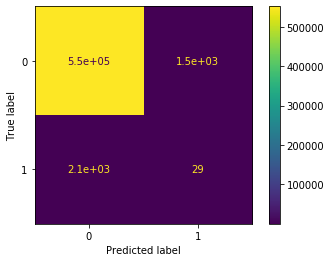

In [76]:
# summarize the fit of the model
expected = y
predicted = model.predict(X)
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
plot_confusion_matrix(model, X, y)

# :(

# Logistic regression

In [15]:
X = train_4.drop('is_fraud', axis = 1)
#X = preprocessing.scale(X)
y = train_4.loc[:,'is_fraud']

In [61]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

In [62]:
model.fit(X, y)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1289169
           1       0.89      0.15      0.26      7506

    accuracy                           0.99   1296675
   macro avg       0.94      0.57      0.63   1296675
weighted avg       0.99      0.99      0.99   1296675

[[1289035     134]
 [   6386    1120]]


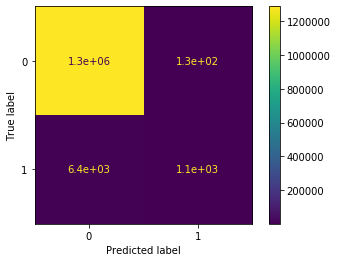

In [63]:
# summarize the fit of the model
expected = y
predicted = model.predict(X)
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
plot_confusion_matrix(model, X, y)

In [64]:
X = test_4.drop('is_fraud', axis = 1)
X = min_max_scale(X, features_to_scale)
y = test_4.loc[:,'is_fraud']

2020-11-10 20:05:40 Min_max_scale: amt
2020-11-10 20:05:40 Min_max_scale: city_pop
2020-11-10 20:05:41 Min_max_scale: trans_distance
2020-11-10 20:05:41 Min_max_scale: life_time_days
2020-11-10 20:05:41 Min_max_scale: merchant_target_share
2020-11-10 20:05:42 Min_max_scale: birth_year


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.54      0.05      0.09      2145

    accuracy                           1.00    555719
   macro avg       0.77      0.52      0.54    555719
weighted avg       0.99      1.00      0.99    555719

[[553484     90]
 [  2039    106]]


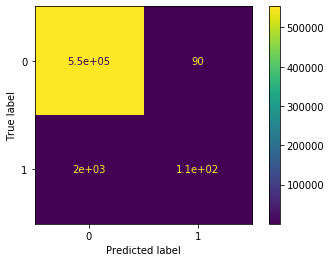

In [65]:
# summarize the fit of the model
expected = y
predicted = model.predict(X)
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
plot_confusion_matrix(model, X, y)

In [21]:
y_true = y # ground truth labels
y_probas = model.predict_proba(X) # predicted probabilities generated by sklearn classifier
#skplt.metrics.plot_roc(y_true, y_probas)
#plt.show()

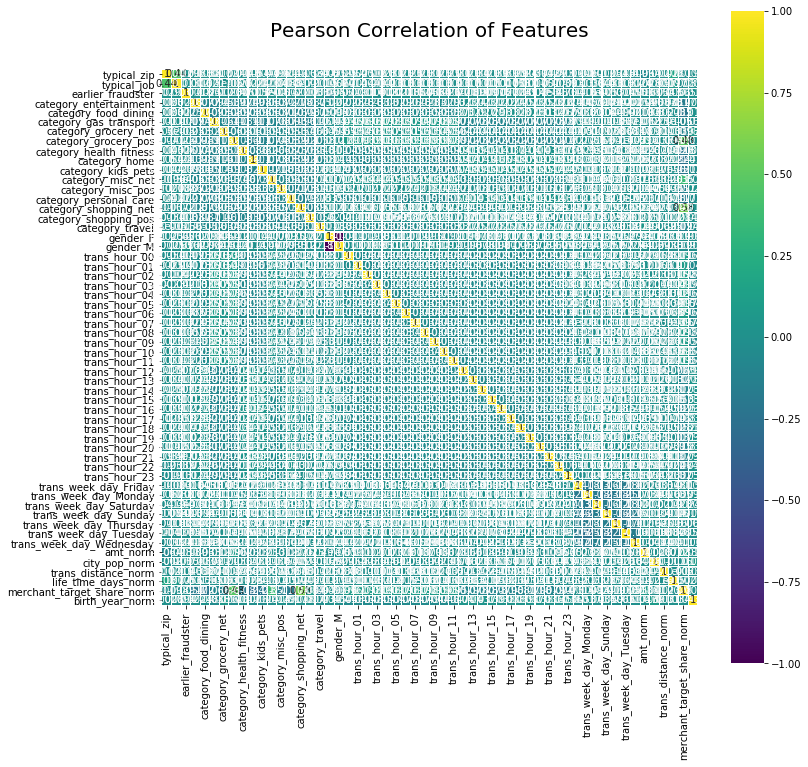

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=20)
sns.heatmap(X.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [90]:
fi=pd.DataFrame({'importance':model.feature_importances_},index=X.columns)
fi.sort_values('importance',ascending=False).head(15)

,importance
category_grocery_pos,0.164521
category_gas_transport,0.150126
typical_zip,0.080986
earlier_fraudster,0.058432
trans_hour_23,0.053969
trans_hour_22,0.038651
amt_norm,0.037354
category_entertainment,0.028764
trans_hour_17,0.026035
category_home,0.024919


# Early stopping

In [115]:
train_5 = min_max_scale(train_3, features_to_scale)

2020-11-10 21:56:08 Min_max_scale: amt
2020-11-10 21:56:09 Min_max_scale: city_pop
2020-11-10 21:56:09 Min_max_scale: trans_distance
2020-11-10 21:56:10 Min_max_scale: life_time_days
2020-11-10 21:56:11 Min_max_scale: merchant_target_share
2020-11-10 21:56:11 Min_max_scale: birth_year


In [116]:
from sklearn.pipeline import Pipeline, make_pipeline
from category_encoders import TargetEncoder # bonus: sklearn-contrib

target_encoder = TargetEncoder(cols=test_5.select_dtypes(include=[object]).columns)
estimator = XGBClassifier(nthread=-1, n_estimators=1000, learning_rate=0.1)

pipeline = Pipeline([
    ('my_encoder', target_encoder),
    ('my_estimator', estimator)
])

In [117]:
X, X_test, y, y_test = train_test_split(test_5, test_5['is_fraud'],
                                         stratify=test_5['is_fraud'],
                                         test_size=0.3,
                                         random_state=43)

# отделяем от данных для обучения небольшой сэмпл для early_stopping
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                 stratify=y,
                                                 test_size=0.1,
                                                 random_state=43)

# итого
X_train.shape, X_val.shape, X_test.shape

((350102, 14), (38901, 14), (166716, 14))

In [118]:
X_train = X_train.drop(['is_fraud'], axis=1)
X_val = X_val.drop(['is_fraud'], axis=1)
X_test = X_test.drop(['is_fraud'], axis=1)

In [119]:
from sklearn.base import clone

initial_steps = []
for i in pipeline.steps:
    initial_steps.append(clone(i[1]))

transformers_pipeline = make_pipeline(*initial_steps[:-1])
transformers_pipeline.fit(X_train, y_train)

X_val_transformed = transformers_pipeline.transform(X_val)

In [120]:
# передаем в fit параметры для early_stopping как: my_estimator__eval_set
pipeline.fit(X_train, y_train,
            my_estimator__eval_set=[(X_val_transformed, y_val)], 
            my_estimator__eval_metric='auc', 
            my_estimator__early_stopping_rounds=10, 
            my_estimator__verbose=10)

[0]	validation_0-auc:0.98782
Will train until validation_0-auc hasn't improved in 10 rounds.
[10]	validation_0-auc:0.98912
[20]	validation_0-auc:0.98983
[30]	validation_0-auc:0.99107
[40]	validation_0-auc:0.99524
[50]	validation_0-auc:0.99618
[60]	validation_0-auc:0.99687
[70]	validation_0-auc:0.99758
[80]	validation_0-auc:0.99788
[90]	validation_0-auc:0.99824
[100]	validation_0-auc:0.99847
[110]	validation_0-auc:0.99875
[120]	validation_0-auc:0.99887
[130]	validation_0-auc:0.99895
[140]	validation_0-auc:0.99904
[150]	validation_0-auc:0.99920
[160]	validation_0-auc:0.99928
[170]	validation_0-auc:0.99929
[180]	validation_0-auc:0.99931
[190]	validation_0-auc:0.99937
[200]	validation_0-auc:0.99939
[210]	validation_0-auc:0.99941
[220]	validation_0-auc:0.99940
[230]	validation_0-auc:0.99941
[240]	validation_0-auc:0.99943
[250]	validation_0-auc:0.99945
[260]	validation_0-auc:0.99941
Stopping. Best iteration:
[251]	validation_0-auc:0.99945



Pipeline(memory=None,
         steps=[('my_encoder',
                 TargetEncoder(cols=Index(['category', 'gender', 'trans_hour', 'trans_week_day'], dtype='object'),
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', min_samples_leaf=1,
                               return_df=True, smoothing=1.0, verbose=0)),
                ('my_estimator',
                 XGBClassifier(base_score=0.5, booster=None,
                               colsample_bylevel=1, colsample_...
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints=None, n_estimators=1000,
                               n_jobs=-1, nthread=-1, num_parallel_tree=1,
                               objective='binary:logistic', random_state=0,
           

In [111]:
y_pred = pipeline.predict_proba(X_test)
y_pred

array([[9.9991328e-01, 8.6717846e-05],
       [9.9986333e-01, 1.3667617e-04],
       [9.9999493e-01, 5.0489016e-06],
       ...,
       [9.9999893e-01, 1.0563210e-06],
       [9.9998224e-01, 1.7764147e-05],
       [9.9999428e-01, 5.7059815e-06]], dtype=float32)

In [112]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_pred[:, 1])

0.9992676322534954

In [129]:
y_pred = pipeline.predict_proba(X_t)
y_pred

array([[9.9993300e-01, 6.6977882e-05],
       [9.9997318e-01, 2.6818727e-05],
       [9.9995112e-01, 4.8895352e-05],
       ...,
       [9.9999940e-01, 6.1562764e-07],
       [9.9999690e-01, 3.0842984e-06],
       [9.9999559e-01, 4.3978825e-06]], dtype=float32)

In [130]:
roc_auc_score(y_t, y_pred[:, 1])

0.9997502619616375

In [131]:
y_true = y_t # ground truth labels
y_probas = y_pred
#skplt.metrics.plot_roc(y_true, y_probas)
#plt.show()
data_tuples = list(zip(y_true,list(y_probas[:,1])))
compare = pd.DataFrame(data_tuples, columns=['y_true','y_probas'])
compare['y_probas'] = compare['y_probas'].round(3)
compare.head(500000).to_excel('compare_5.xlsx', index = False)

In [125]:
X_t = test_3.drop('is_fraud', axis = 1)
X_t = min_max_scale(X_t, features_to_scale)
y_t = test_3.loc[:,'is_fraud']

2020-11-10 21:59:48 Min_max_scale: amt
2020-11-10 21:59:49 Min_max_scale: city_pop
2020-11-10 21:59:49 Min_max_scale: trans_distance
2020-11-10 21:59:49 Min_max_scale: life_time_days
2020-11-10 21:59:50 Min_max_scale: merchant_target_share
2020-11-10 21:59:50 Min_max_scale: birth_year


In [126]:
X_t

,category,gender,trans_hour,trans_week_day,typical_zip,typical_job,earlier_fraudster,amt_norm,city_pop_norm,trans_distance_norm,life_time_days_norm,merchant_target_share_norm,birth_year_norm
0,personal_care,M,12,Sunday,1,1,1,0.000082,0.114727,0.162054,0.734620,0.042814,0.543210
1,personal_care,F,12,Sunday,1,1,1,0.001267,0.000096,0.694975,0.734434,0.106507,0.814815
2,health_fitness,F,12,Sunday,1,1,1,0.001769,0.011860,0.390960,0.735223,0.045309,0.567901
3,misc_pos,M,12,Sunday,1,1,0,0.002594,0.018834,0.182858,0.734717,0.167050,0.777778
4,travel,M,12,Sunday,1,1,1,0.000096,0.000379,0.691062,0.734697,0.046781,0.382716
...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,health_fitness,M,23,Thursday,1,1,0,0.001879,0.000171,0.509967,0.998946,0.092449,0.518519
555715,kids_pets,M,23,Thursday,1,1,1,0.004868,0.009879,0.662808,0.998994,0.051106,0.925926
555716,kids_pets,F,23,Thursday,1,1,1,0.003772,0.001260,0.534723,0.998667,0.051856,0.703704
555717,travel,M,23,Thursday,1,1,1,0.000307,0.000036,0.350198,0.999780,0.145781,0.506173
